# Calculate titers of spike-pseudotyped lentiviruses on different cell lines

In [1]:
import os
import warnings

import math
import numpy as np 

from IPython.display import display, HTML
import matplotlib.pyplot as plt

from neutcurve.colorschemes import CBMARKERS, CBPALETTE

import pandas as pd
from plotnine import *

import yaml

In [2]:
warnings.simplefilter('ignore')

Read config


In [3]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Make output directory if needed

In [4]:
resultsdir=config['resultsdir']
os.makedirs(resultsdir, exist_ok=True)

In [5]:
titers = pd.read_csv(config['virus_titers'])

titers = (titers
          .assign(RLUperuL=lambda x: x['RLU_per_well'] / x['uL_virus'],
                  date=lambda x: x['date'].astype(str)
                 )
         )

display(HTML(titers.head().to_html(index=False)))

plasmid,replicate,virus,dilution,uL_virus,RLU_per_well,date,cells,2727_plasmid,amphoB,RLUperuL
2800,rep1,Wu_1,0.50000,50.000,2355075,220512,very low,6well_pooled,amphoB,47101.50
2800,rep1,Wu_1,0.25000,25.000,983529,220512,very low,6well_pooled,amphoB,39341.16
2800,rep1,Wu_1,0.12500,12.500,414824,220512,very low,6well_pooled,amphoB,33185.92
2800,rep1,Wu_1,0.06250,6.250,206776,220512,very low,6well_pooled,amphoB,33084.16
2800,rep1,Wu_1,0.03125,3.125,100609,220512,very low,6well_pooled,amphoB,32194.88


In [6]:
#pandas make a new df that only has replicate 1

rep1_df = titers.loc[titers['replicate'] == 'rep1']
rep1_df

,plasmid,replicate,virus,dilution,uL_virus,RLU_per_well,date,cells,2727_plasmid,amphoB,RLUperuL
0,2800,rep1,Wu_1,0.500000,50.000000,2355075,220512,very low,6well_pooled,amphoB,47101.50
1,2800,rep1,Wu_1,0.250000,25.000000,983529,220512,very low,6well_pooled,amphoB,39341.16
2,2800,rep1,Wu_1,0.125000,12.500000,414824,220512,very low,6well_pooled,amphoB,33185.92
3,2800,rep1,Wu_1,0.062500,6.250000,206776,220512,very low,6well_pooled,amphoB,33084.16
4,2800,rep1,Wu_1,0.031250,3.125000,100609,220512,very low,6well_pooled,amphoB,32194.88
5,2800,rep1,Wu_1,0.015625,1.562500,52694,220512,very low,6well_pooled,amphoB,33724.16
6,2800,rep1,Wu_1,0.007812,0.781250,27828,220512,very low,6well_pooled,amphoB,35619.84
7,2800,rep1,Wu_1,0.003906,0.390625,15777,220512,very low,6well_pooled,amphoB,40389.12
16,2800,rep1,Wu_1,0.500000,50.000000,5861082,220512,low,6well_pooled,amphoB,117221.64
17,2800,rep1,Wu_1,0.250000,25.000000,2245067,220512,low,6well_pooled,amphoB,89802.68


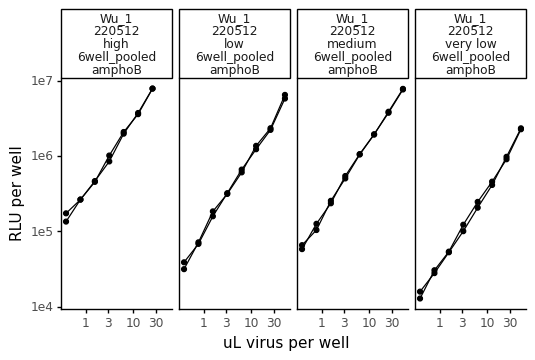

In [17]:
ncol=min(8, titers['virus'].nunique())
nrow=math.ceil(titers['virus'].nunique() / ncol)

p = (ggplot(titers.dropna()
            ) +
     aes('uL_virus', 'RLU_per_well', group='replicate') +
     geom_point(size=1.5) +
     geom_line() +
     facet_wrap('~virus+date+cells+2727_plasmid+amphoB', ncol=4) +
     scale_y_log10(name='RLU per well') +
     scale_x_log10(name='uL virus per well') +
     theme_classic() +
     theme(axis_text_x=element_text(),
           figure_size=(6,3),
           )
     )

_ = p.draw()
plt.savefig('080422titersdilutions.png')

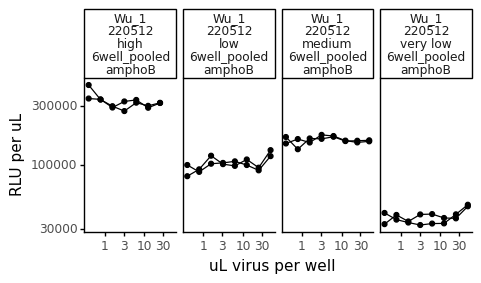

In [21]:
p = (ggplot(titers.dropna()
            ) +
     aes('uL_virus', 'RLUperuL', group='replicate') +
     geom_point(size=1.5) +
     geom_line() +
     facet_wrap('~virus+date+cells+2727_plasmid+amphoB', ncol=4) +
     scale_y_log10(name='RLU per uL') +
     scale_x_log10(name='uL virus per well') +
     theme_classic() +
     theme(axis_text_x=element_text(),
           figure_size=(5,2),
           ) 
     )

_ = p.draw()

From visual inspection of the above plots, it appears that only the 5 highest dilutions (i.e., >1uL of virus per well) are reliable enough to calculate titers. 

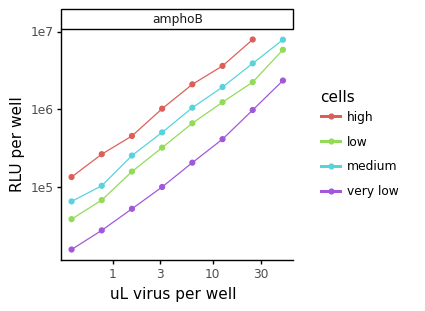

In [22]:
#new
ncol=min(8, titers['virus'].nunique())
nrow=math.ceil(titers['virus'].nunique() / ncol)

p = (ggplot(rep1_df.dropna()
            ) +
     aes('uL_virus', 'RLU_per_well', group='cells', color= 'cells') +
     geom_point(size=1.5) +
     geom_line() +
     scale_y_log10(name='RLU per well') +
     scale_x_log10(name='uL virus per well') +
     facet_wrap('amphoB', ncol=2) +
     theme_classic() +
     theme(axis_text_x=element_text(),
           figure_size=(3,3),
           )
     )

_ = p.draw()
plt.savefig('080422titersdilutions.png')

In [23]:
#new
average_titers1 = (titers
                  .dropna() # missing values for some replicates
                  .query('uL_virus > 1') # drop lowest concentration of virus
                  .groupby(['virus', 'replicate', 'date', 'cells', '2727_plasmid', 'amphoB','dilution'])
                  .agg(mean_RLUperuL=pd.NamedAgg(column='RLUperuL', aggfunc=np.mean))
                  .reset_index()
                 )

display(HTML(average_titers1.head().to_html(index=False)))

virus,replicate,date,cells,2727_plasmid,amphoB,dilution,mean_RLUperuL
Wu_1,rep1,220512,high,6well_pooled,amphoB,0.015625,291884.16
Wu_1,rep1,220512,high,6well_pooled,amphoB,0.031250,327239.36
Wu_1,rep1,220512,high,6well_pooled,amphoB,0.062500,336602.24
Wu_1,rep1,220512,high,6well_pooled,amphoB,0.125000,290649.68
Wu_1,rep1,220512,high,6well_pooled,amphoB,0.250000,317654.88


In [24]:
average_titers = (titers
                  .dropna() # missing values for some replicates
                  .query('uL_virus > 1') # drop lowest concentration of virus
                  .groupby(['virus', 'replicate', 'date', 'cells', '2727_plasmid', 'amphoB'])
                  .agg(mean_RLUperuL=pd.NamedAgg(column='RLUperuL', aggfunc=np.mean))
                  .reset_index()
                 )

display(HTML(average_titers.head().to_html(index=False)))

virus,replicate,date,cells,2727_plasmid,amphoB,mean_RLUperuL
Wu_1,rep1,220512,high,6well_pooled,amphoB,312806.064000
Wu_1,rep1,220512,low,6well_pooled,amphoB,102924.786667
Wu_1,rep1,220512,medium,6well_pooled,amphoB,160672.613333
Wu_1,rep1,220512,very low,6well_pooled,amphoB,36438.630000
Wu_1,rep2,220512,high,6well_pooled,amphoB,302495.504000


In [25]:
cat_order = ['very low', 'low', 'medium', 'high']
average_titers['cells'] = pd.Categorical(average_titers['cells'], categories=cat_order, ordered=True)

average_titers

,virus,replicate,date,cells,2727_plasmid,amphoB,mean_RLUperuL
0,Wu_1,rep1,220512,high,6well_pooled,amphoB,312806.064000
1,Wu_1,rep1,220512,low,6well_pooled,amphoB,102924.786667
2,Wu_1,rep1,220512,medium,6well_pooled,amphoB,160672.613333
3,Wu_1,rep1,220512,very low,6well_pooled,amphoB,36438.630000
4,Wu_1,rep2,220512,high,6well_pooled,amphoB,302495.504000
5,Wu_1,rep2,220512,low,6well_pooled,amphoB,108748.243333
6,Wu_1,rep2,220512,medium,6well_pooled,amphoB,160088.590000
7,Wu_1,rep2,220512,very low,6well_pooled,amphoB,38693.633333


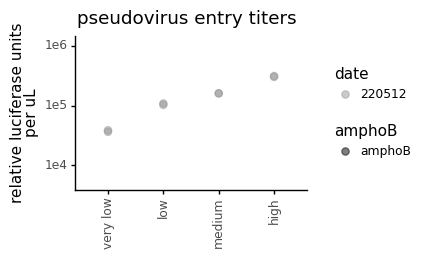

In [26]:
p = (ggplot(average_titers, 
            aes(x='cells', y='mean_RLUperuL', color='date', shape = 'amphoB')
           ) +
     geom_point(size=2.5, alpha=0.5)+
     theme_classic() +
     theme(axis_text_x=element_text(angle=90, vjust=1, hjust=0.5),
           figure_size=(average_titers['virus'].nunique()*3,2),
           axis_title_x=element_blank(),
          ) +
     scale_y_log10(limits=[5e3,1.1e6]) +
     ylab('relative luciferase units\nper uL')+
     labs(title='pseudovirus entry titers') +
     scale_color_manual(values=CBPALETTE)
    )

_ = p.draw()

Calculate how much virus to use in neut assays:

In [28]:
target_RLU = 2e5
uL_virus_per_well = 50

dilute_virus = (average_titers
                .groupby(['virus', 'date', 'cells', '2727_plasmid','amphoB'])
                .agg(RLUperuL=pd.NamedAgg(column='mean_RLUperuL', aggfunc=np.mean))
                .reset_index()
                .assign(target_RLU = target_RLU,
                        uL_virus_per_well = uL_virus_per_well,
                        dilution_factor = lambda x: x['RLUperuL']/target_RLU*uL_virus_per_well,
                        uL_per_8mL = lambda x: 8000/x['dilution_factor'],
                        media_for_8ml = lambda x: 8000 - 8000/x['dilution_factor']
                       )
               )


titerfile = os.path.join(resultsdir, 'virus_titers.csv')
print(f"Saving to {titerfile}")

dilute_virus.to_csv(titerfile, index=False)

display(HTML(dilute_virus.to_html(index=False)))

Saving to results/virus_titers.csv


virus,date,cells,2727_plasmid,amphoB,RLUperuL,target_RLU,uL_virus_per_well,dilution_factor,uL_per_8mL,media_for_8ml
Wu_1,220512,very low,6well_pooled,amphoB,37566.131667,200000.0,50,9.391533,851.831120,7148.168880
Wu_1,220512,low,6well_pooled,amphoB,105836.515000,200000.0,50,26.459129,302.353115,7697.646885
Wu_1,220512,medium,6well_pooled,amphoB,160380.601667,200000.0,50,40.095150,199.525377,7800.474623
Wu_1,220512,high,6well_pooled,amphoB,307650.784000,200000.0,50,76.912696,104.014037,7895.985963


In [15]:
# !jupyter nbconvert calculate_titer.ipynb --to HTML